In [2]:
#Defined as pixels in the image that end up having an impact on the classification of the image

In [18]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import keras

In [33]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [34]:
def model():
  base_model=InceptionV3(include_top=True,weights='imagenet',input_shape=(300,300,3))
  x=tf.keras.layers.Activation('softmax')(base_model)
  x=tf.keras.Model(inputs=base_model.input,outputs=x)

  return x



In [36]:
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
    tf.keras.layers.Activation('softmax')
])

# build the model based on a specified batch input shape
model.build([None, 300, 300, 3])

In [37]:
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

--2021-12-12 11:20:58--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:15b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211346 (206K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 206.39K  --.-KB/s    in 0.05s   

2021-12-12 11:20:58 (3.67 MB/s) - ‘image.jpg’ saved [211346/211346]



In [38]:
img=cv2.imread('image.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

(720, 960, 3)

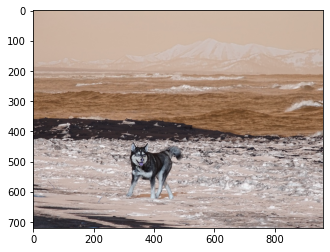

In [40]:
plt.imshow(img)
img.shape

In [41]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

(720, 960, 3)

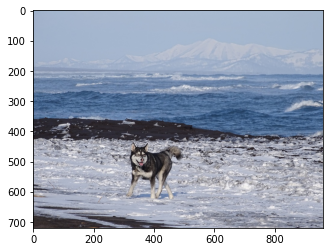

In [42]:
plt.imshow(img)
img.shape

In [43]:
img = cv2.resize(img, (300, 300)) / 255.0

In [44]:
image = np.expand_dims(img, axis=0)

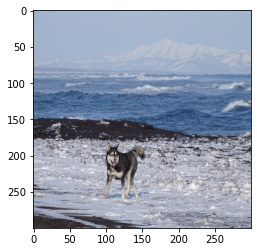

In [45]:
plt.imshow(img)

In [46]:
loss_object=tf.keras.losses.CategoricalCrossentropy()

In [48]:
class_index=251
num_classes=1001

expected_output=tf.one_hot([class_index]*image.shape[0],num_classes)

with tf.GradientTape() as tape:
  inputs=tf.cast(image,tf.float32)
  tape.watch(inputs)
  predictions=model(inputs)
  loss=loss_object(expected_output,predictions)

gradients=tape.gradient(loss,inputs)

In [49]:
gradients.shape

TensorShape([1, 300, 300, 3])

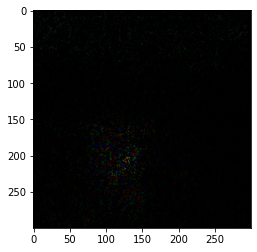

In [51]:
plt.imshow(gradients[0])

In [52]:
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

In [59]:
grayscale_tensor[0].shape

TensorShape([300, 300])

In [55]:
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(,grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,)

In [56]:
normalized_tensor = tf.squeeze(normalized_tensor)

In [57]:
print(np.max(grayscale_tensor[0]))
print(np.min(grayscale_tensor[0]))
print()

1.2167073
0.0



In [60]:
max_pixel = np.unravel_index(,np.argmax(grayscale_tensor[0]), grayscale_tensor[0].shape)
min_pixel = np.unravel_index(np.argmin(grayscale_tensor[0]), grayscale_tensor[0].shape)
print(max_pixel)
print(min_pixel)
print()

(203, 129)
(0, 299)



In [61]:
print(normalized_tensor[max_pixel])
print(normalized_tensor[min_pixel])

tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)


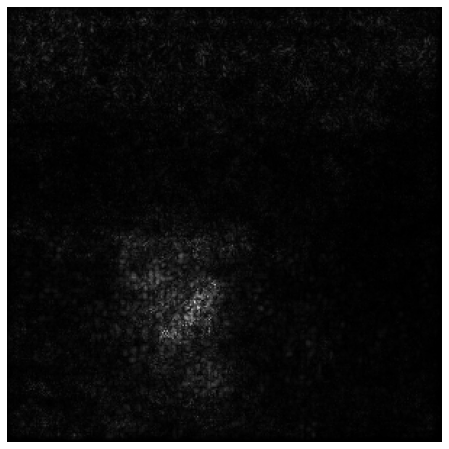

In [62]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

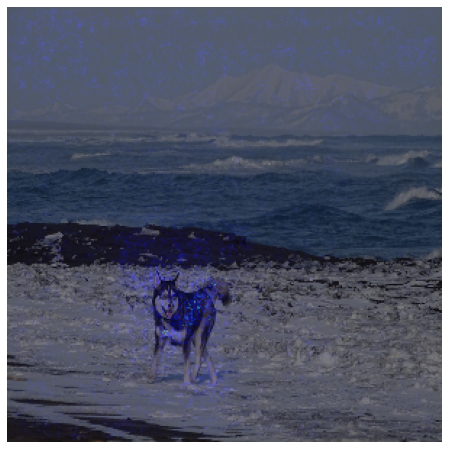

In [63]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()